### Probate records data noodling
Data set from Gloria Main, emerita U Colorado:
http://eh.net/database/new-england-1631-1776-sample-of-18509-probates/

Code by Shane Landrum, <srl@cliotropic.org>


In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


data_file = 'Main-Main-New-Eng-probates-2013.xlsx'
                       
# get the main data set. This is the big table.
def probate_records():
    pr = pd.read_excel( data_file,
                        sheetname='main data set', 
                        header=0,
                        skiprows=4, 
                        skip_footer=19,
                        index_col=0, 
                        parse_cols='A:C,M:T')  # basic year and life cycle information
    return pr.fillna('')

# map colonies to colony numbers.
def colonies():
    c = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0,
                      skiprows=4,
                      skip_footer=270,
                      parse_cols="A,B,C")
    return c.fillna('')

# map counties to county numbers.
def counties():
    c = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0,
                      skiprows=15,
                      skip_footer=251,
                      parse_cols="A,B,C")
    return c.fillna('')

# map towns to town codes.
def towns():
    t = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0, 
                      skiprows=4,
                      skip_footer=2,
                      parse_cols="M:Q")
    return t.fillna('')

# map occupations to occupation codes.
def occupations():
    t = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0, 
                      skiprows=33,
                      skip_footer=236,
                      parse_cols="A,B")
    return t.fillna('')

def lifestages():
    t = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0, 
                      skiprows=53,
                      skip_footer=219,
                      parse_cols="A,C")
    return t.fillna('')
 

def bigtable():
    # This will take some time because the data file is 6.5MB.
    
    # merge tables to bring in colony names.
    bt = probate_records().merge(colonies(), how="left", left_on="colony", right_index=True)
    # Move textual names for colonies into the 'colony' column, drop the badly-labeled 'This is' column
    bt['colony'] = bt['This is']
    bt = bt.drop(['This is'], 1)
    bt = bt.drop(['Sample n ='], 1) # Not sure why this is getting added, but make it go away

    
    # merge tables to bring in county names.
    bt = bt.merge(counties(), how="left", left_on="county", right_index=True)
    # Move textual names for counties into the 'county' column, drop the badly-labeled 'This is' column
    bt['county'] = bt['This is']
    bt = bt.drop(['This is'], 1)

    # merge tables to bring in occupation names.
    bt = bt.merge(occupations(), how="left", left_on="xocc", right_index=True)
    # Move textual names for occupations into the 'xocc' column, drop the badly-labeled 'This is' column
    bt['xocc'] = bt['This is']
    bt = bt.drop(['This is'], 1)

    # merge tables to bring in life cycle stages.
    bt = bt.merge(lifestages(), how="left", left_on="newlc", right_index=True)
    # Move textual names for life stages into the 'newlc' column, drop the badly-labeled 'This is' column
    bt['newlc'] = bt['This is']
    bt = bt.drop(['This is'], 1)

    
    # merge tables to bring in town names. 
    townlabels = towns()["This town is"].to_frame()
    bt = bt.merge(townlabels, how="left", left_on="town", right_index=True)
    # Move textual names for towns into the 'town' column, drop the badly-labeled 'This town is' column
    bt['town'] = bt['This town is']
    bt = bt.drop(['This town is'], 1)
    bt = bt.drop(['sample n ='], 1) # Not sure why this is getting added, but make it go away
    
    return(bt)

# Ages at death graphic

This shows a basically random distribution of deaths across years, with some years when deaths were more common.
For example, something in the mid-1670s happened to kill a lot of younger men. I'm guessing it was the Pequot
War. 

I haven't researched historically to see whether those deaths correlate with wars or epidemics, or 
whether they're just an artifact of the sampling method that brought us this data set. 

<IPython.core.display.Javascript object>


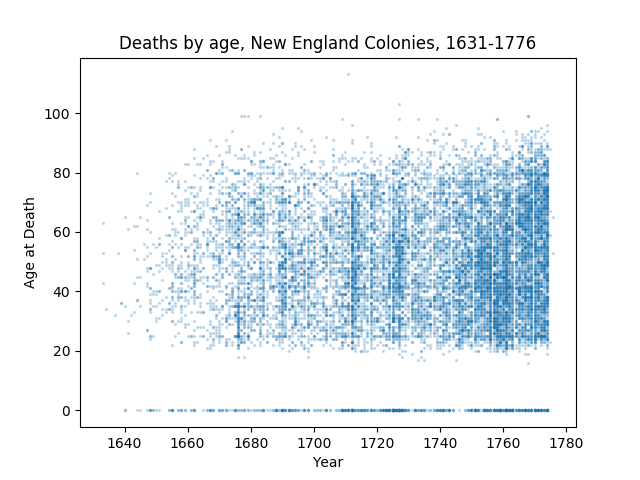

In [66]:
def ages_at_death():
    pr = pd.read_excel( data_file,
                        sheetname='main data set', 
                        header=0,
                        skiprows=4, 
                        skip_footer=19,
                        index_col=0, 
                        parse_cols='A:C')  # basic year and life cycle information
    
    # this is ugly because it drops anyone whose age wasn't recorded, but it's necessary to handle errors.
    return pr #.dropna(axis=0, how='any', inplace=True)



def plot_deaths(d):
    
    fig, ax = plt.subplots()
    
    # can't just do this, because pandas datetime starts in 1677: 
    #   http://pandas-docs.github.io/pandas-docs-travis/timeseries.html#timestamp-limitations
    #year = pd.to_datetime(d['year'], format="%Y")
    
    year = d['year'].astype('int32')
    
    # we should deal with the empty age fields somehow, right now just passing them in as 0.
    age = d['age']
    
    # scatterplot of age and year of death
    ax.scatter(year, age, s=2, alpha=0.2  )


    # x and y axis labeling and such    
    ax.set_ylabel('Age at Death')
    ax.set_xlabel('Year')
    ax.set_title('Deaths by age, New England Colonies, 1631-1776')





#bigtable()    
#data = bt()
death_ages = ages_at_death().dropna(axis=0, how="any")
plot_deaths(death_ages)

<IPython.core.display.Javascript object>


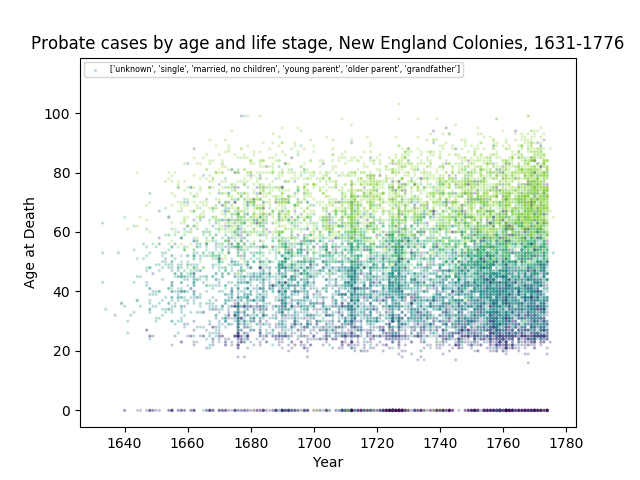

In [89]:
def ages_and_stages_at_death():
    pr = pd.read_excel( data_file,
                        sheetname='main data set', 
                        header=0,
                        skiprows=4, 
                        skip_footer=19,
                        index_col=0, 
                        parse_cols='A:C, R')  # basic year and life cycle stage information
    
    
    # merge tables to bring in life cycle stages.
    pr = pr.merge(lifestages(), how="left", left_on="newlc", right_index=True)
    # Move textual names for life stages into the 'newlc' column, drop the badly-labeled 'This is' column
    pr.rename(index=str, columns={'This is:': "life stage"})
    
    # remove people with NaNs (mostly for age)
    pr.dropna(axis=0, how="any", inplace=True)

    return pr 


def plot_deaths_by_stages(d):
    
    fig, ax = plt.subplots()
        
    year = d['year'].astype('int32')
    
    # we should deal with the empty age fields somehow, right now just passing them in as 0.
    age = d['age']
    #labels = lifestages().values[0:6]
    
    labels = ['unknown', 'single', 'married, no children', 'young parent', 'older parent', 'grandfather']
    
    # scatterplot of age and year of death, colored by life stage
    ax.scatter(year, age, s=2, c=d['newlc'], alpha=0.2, label=labels  )
    
    # legend for the colors
    ax.legend([labels], loc=2, fontsize='xx-small')
    
    # x and y axis labeling and such    
    ax.set_ylabel('Age at Death')
    ax.set_xlabel('Year')
    ax.set_title('Probate cases by age and life stage, New England Colonies, 1631-1776')

death_ages = ages_and_stages_at_death()
plot_deaths_by_stages(death_ages)


